In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.ndimage import rotate
import os
import PIL
from tensorflow.keras import layers
from astropy import stats
import time
from IPython import display
import sys
from tqdm.notebook import tqdm
import random
from astropy.io import fits 
from scipy.ndimage import rotate
import tensorflow_docs.vis.embed as embed

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
def augment(files, m):

    """
    Augmenting for real data images where the ammount of data needs to be scaled up by applying rotations and flips.
    Performs preprocessing including sigma clipping, normalisation and removing nans.
    Upscales by a factor of 2*m
    """
    
    array = np.empty([len(files)*m*2, 128, 128])
    #rotation = np.linspace(0, 360, m, endpoint=False)
    
    sigma = 1
    
    it = 0
    i = 0
    pbar = tqdm(total=len(array))
    while i < len(files):
        image = fits.open(files[i])[0].data.squeeze()
        
        mean, median, std = stats.sigma_clipped_stats(image, sigma=sigma)
        image[image < median+sigma*std] = median+sigma*std
        image = 2*((image-np.min(image))/np.ptp(image))-1
        image = np.where(np.isnan(image), 0, image)
        mean_n, median_n, std_n = stats.sigma_clipped_stats(image, sigma=sigma)
        
        j = 0
        while j < m:        
            image_rot1 = rotate(image, rotation[j], reshape=False, cval = median_n)
            image_rot1[image_rot1 > 1] = 1
            image_rot1[image_rot1 < -1] = -1
            image_rot2 = np.fliplr(image_rot1)
            array[it] = image_rot1
            array[it+1] = image_rot2                    
            pbar.update(2)
            it+=2
            j+=1
        i+=1
        
    return array

In [5]:
def show_images(images, num):
    """
    Visualising the images
    """
        
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]

        plt.imshow(image, cmap='inferno')
        plt.axis('off')
    plt.show()

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=inputshape))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    #print(model.summary())

    return model

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(size//4*size//4*BATCH_SIZE, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((size//4, size//4, BATCH_SIZE)))
    assert model.output_shape == (None, size//4, size//4, BATCH_SIZE) # Note: None is the batch size

    model.add(layers.Conv2DTranspose( BATCH_SIZE//2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, size//4, size//4, BATCH_SIZE//2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(BATCH_SIZE//4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, size//2, size//2, BATCH_SIZE//4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, size, size, 1)
    
    #print(model.summary())
    return model


In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='inferno')
        plt.axis('off')

    plt.savefig('GAN images\gan results6\image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [12]:
def train(dataset, epochs):
    pbar = tqdm(total=epochs)
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #    checkpoint.save(file_prefix = checkpoint_prefix)

        pbar.update(1)    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [13]:
def generate_images(model, num):
    noise_input = tf.random.normal([num, noise_dim])
    predictions = model(noise_input, training=False)
    n = predictions.shape[0]
    cols = 8
    rows = (n-1)//cols+1
    fig = plt.figure(figsize=(16,2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='inferno')
        plt.axis('off')
    plt.show()

In [14]:
#importing real filaments

files1 = glob.glob(r'Raw Data\Filaments\cut*')

In [16]:
images = augment(files1)

  0%|          | 0/1316 [00:00<?, ?it/s]

In [17]:
#check correct preprocessing
num_images, size, _ = images.shape
print(num_images)
print(np.max(images), np.min(images))

1316
1.0 -1.0


In [18]:
train_images = images.reshape(images.shape[0], size, size, 1).astype('float32')
print(train_images.shape)

inputshape = train_images.shape[1:]

(1316, 128, 128, 1)


In [20]:
shuffle = np.random.permutation(range(len(train_images)))
a = train_images[shuffle]

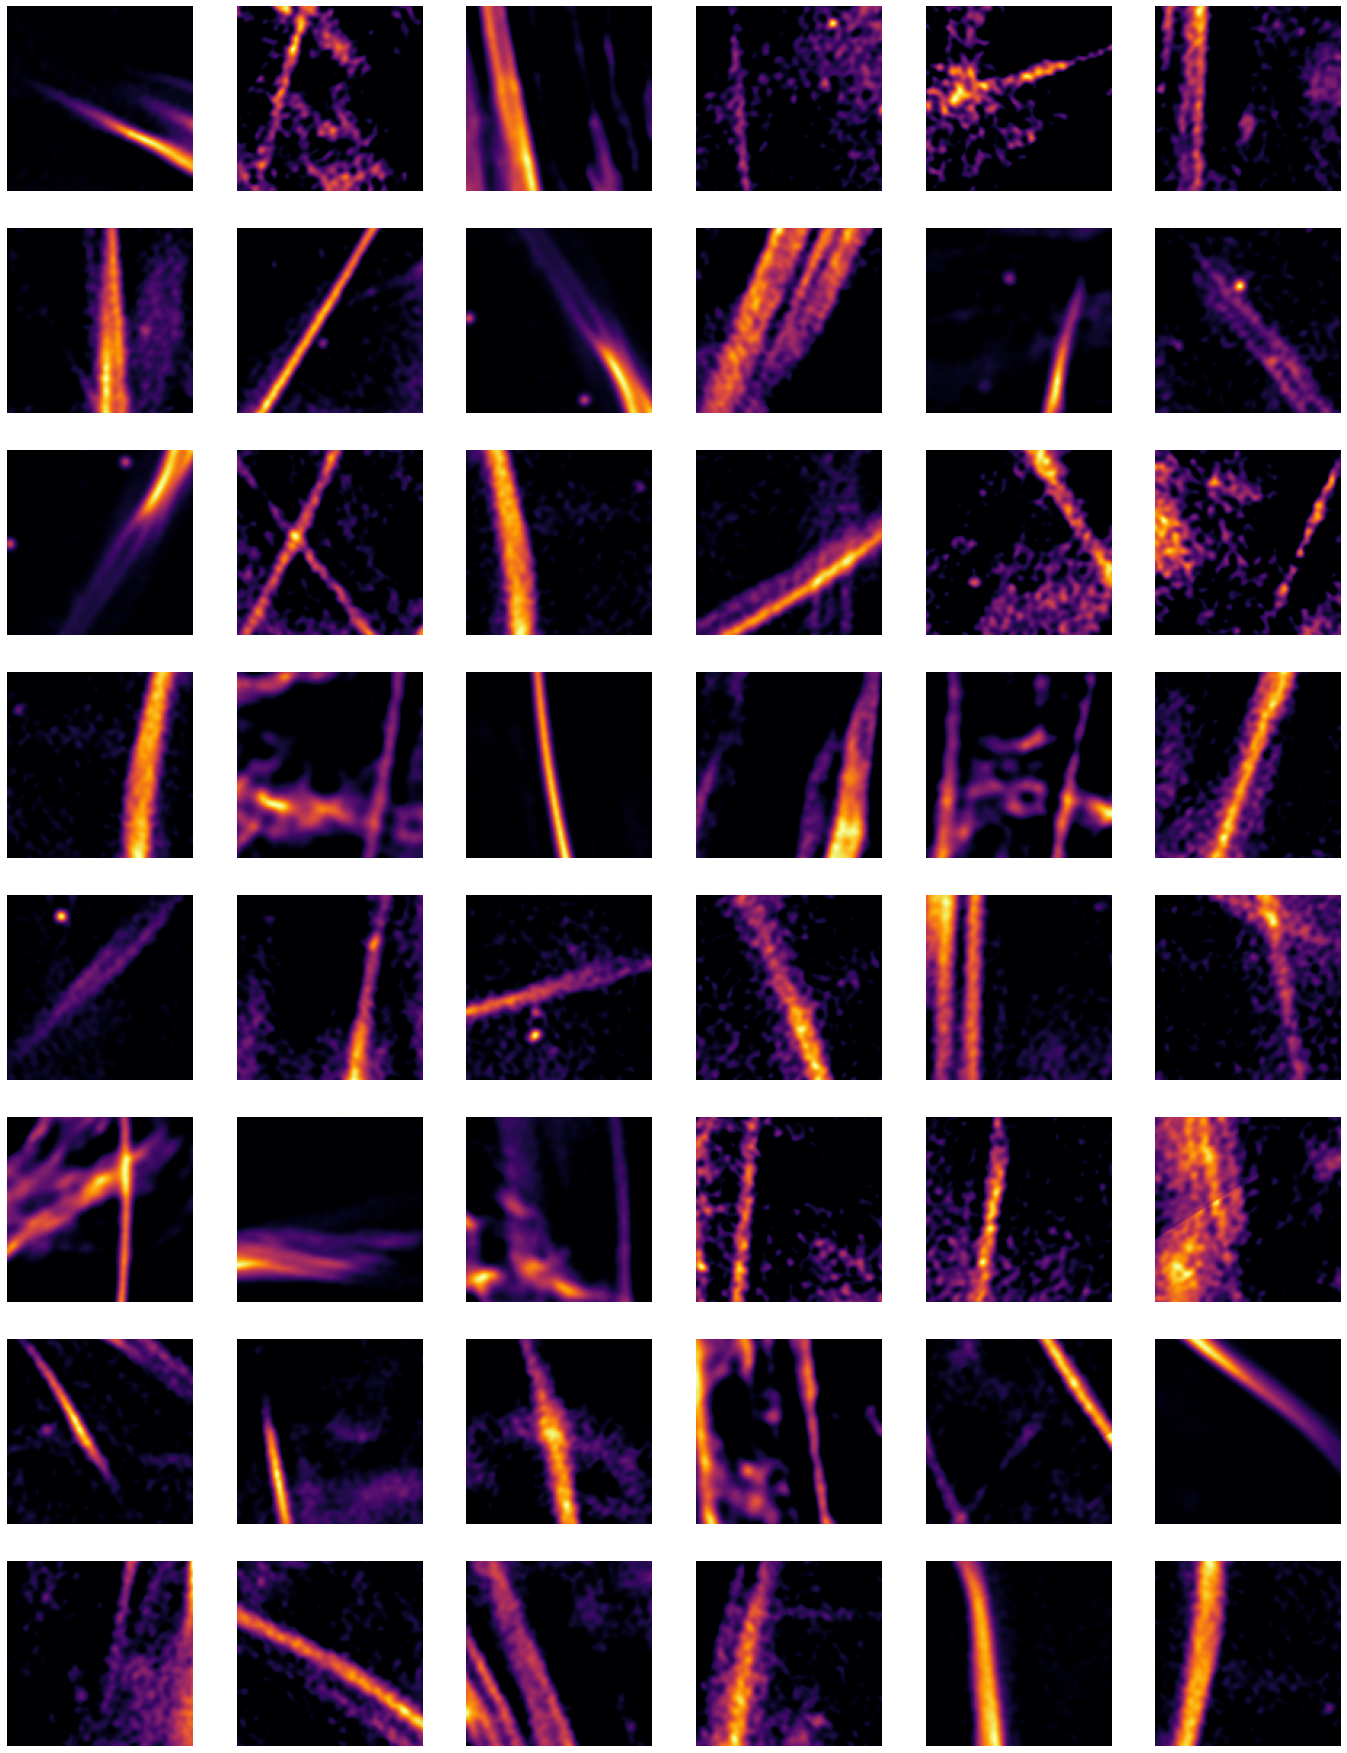

In [21]:
show_images(a, 48)

In [22]:
np.save(r"Data arrays\gan_train_fils.npy", a)

In [20]:
BUFFER_SIZE = len(train_images)//3
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
checkpoint_dir = 'training_checkpoints\GAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [27]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

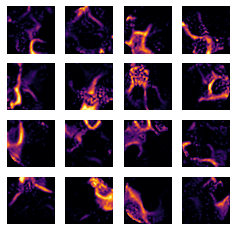

In [28]:
train(train_dataset, EPOCHS)

In [29]:
anim_file = 'GAN images\gan results6\dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('GAN images\gan results6\image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
embed.embed_file(anim_file)

FileNotFoundError: The directory 'C:\\Users\\shari\\anaconda3\\envs\\gpu\\My work\\GAN images\\gan results6' does not exist

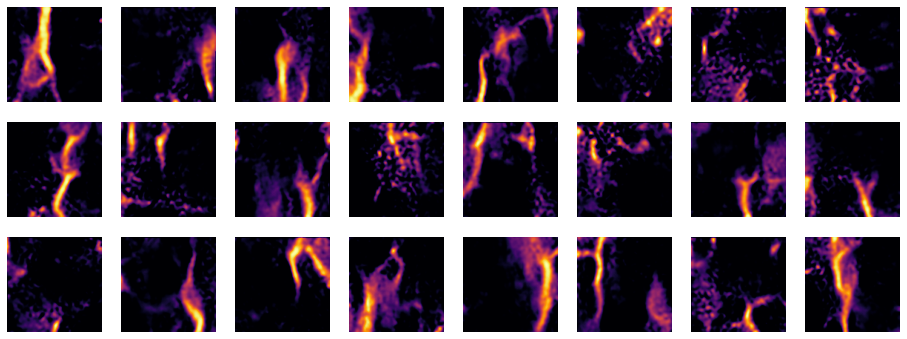

In [48]:
generate_images(generator, 24)

In [69]:
noise_input = tf.random.normal([1000, noise_dim])
predictions = generator(noise_input, training=False)

ResourceExhaustedError: OOM when allocating tensor with shape[1000,65536] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [ ]:
np.save(r'Data arrays\gan_generated_fils3.npy', predictions)